In [1]:
import os
import time
import math
import pickle
import numpy as np
from progress.bar import Bar

In [2]:
face_folder_path = '/workspace/mlcnn/mitcbcl/train/face'
non_face_folder_path = '/workspace/mlcnn/mitcbcl/train/non-face'

In [3]:
def load_pgm_image(file_path):
    with open(file_path, 'rb') as f:
        header = f.readline().decode('ascii')
        assert header.strip() == 'P5', "Not a PGM file or unsupported PGM format."
        
        # Skip comments
        while True:
            line = f.readline().decode('ascii')
            if line[0] != '#':
                break
        
        # Read width, height
        width, height = [int(i) for i in line.split()]
        max_val = int(f.readline().decode('ascii'))  # Max pixel value (e.g. 255)
        
        # Read image data
        img = np.fromfile(f, dtype=np.uint8).reshape((height, width))
        
        return img

def load_all_pgms(folder_path):
    pgm_images = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pgm'):
            file_path = os.path.join(folder_path, file_name)
            img = load_pgm_image(file_path)
            pgm_images.append(img)
    
    # Convert list of images to a single NumPy array
    pgm_images_array = np.array(pgm_images)
    
    return pgm_images_array

In [4]:
face_images = load_all_pgms(face_folder_path)
non_face_images = load_all_pgms(non_face_folder_path)

print(f"face_images: {face_images.shape}")
print(f"non_face_images: {non_face_images.shape}")

face_images: (2429, 19, 19)
non_face_images: (4548, 19, 19)


In [5]:
X = np.concatenate([face_images, non_face_images], axis=0)
y = np.zeros(len(face_images) + len(non_face_images))
y[:len(face_images)] = 1

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (6977, 19, 19)
y: (6977,)


In [6]:
class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def compute_region(self, ii, scale=1.0):
        x1 = int(self.x * scale)
        y1 = int(self.y * scale)
        x2 = x1 + int(self.width * scale) - 1
        y2 = y1 + int(self.height * scale) - 1

        S = int(ii[x2, y2])
        if x1 > 0: S -= int(ii[x1-1, y2])
        if y1 > 0: S -= int(ii[x2, y1-1])
        if x1 > 0 and y1 > 0: S += int(ii[x1 - 1, y1 - 1])
        return S  # Due to the use of substraction with unsigned values


class HaarFeature:
    def __init__(self, positive_regions, negative_regions):
        self.positive_regions = positive_regions  # White
        self.negative_regions = negative_regions  # Black

    def compute_value(self, ii, scale=1.0):
        """
        Compute the value of a feature(x,y,w,h) at the integral image
        """

        sum_pos = sum([rect.compute_region(ii, scale) for rect in self.positive_regions])
        sum_neg = sum([rect.compute_region(ii, scale) for rect in self.negative_regions])
        return sum_neg - sum_pos

In [7]:
def build_filters(img_w, img_h, shift=1, scale_factor=1.25, min_w=4, min_h=4):
    """
    Generate values from Haar features

    White rectangles substract from black ones
    """
    features = []  # [Tuple(positive regions, negative regions),...]

    # Scale feature window
    for w_width in range(min_w, img_w + 1):
        for w_height in range(min_h, img_h + 1):

            # Walk through all the image
            x = 0
            while x + w_width < img_w:
                y = 0
                while y + w_height < img_h:

                    # Possible Haar regions
                    immediate = RectangleRegion(x, y, w_width, w_height)  # |X|
                    right = RectangleRegion(x + w_width, y, w_width, w_height)  # | |X|
                    right_2 = RectangleRegion(x + w_width * 2, y, w_width, w_height)  # | | |X|
                    bottom = RectangleRegion(x, y + w_height, w_width, w_height)  # | |/|X|
                    #bottom_2 = RectangleRegion(x, y + w_height * 2, w_width, w_height)  # | |/| |/|X|
                    bottom_right = RectangleRegion(x + w_width, y + w_height, w_width, w_height)  # | |/| |X|

                    # [Haar] 2 rectagles *********
                    # Horizontal (w-b)
                    if x + w_width * 2 < img_w:
                        features.append(HaarFeature([immediate], [right]))
                    # Vertical (w-b)
                    if y + w_height * 2 < img_h:
                        features.append(HaarFeature([bottom], [immediate]))

                    # [Haar] 3 rectagles *********
                    # Horizontal (w-b-w)
                    if x + w_width * 3 < img_w:
                        features.append(HaarFeature([immediate, right_2], [right]))
                    # # Vertical (w-b-w)
                    # if y + w_height * 3 < img_h:
                    #     features.append(HaarFeature([immediate, bottom_2], [bottom]))

                    # [Haar] 4 rectagles *********
                    if x + w_width * 2 < img_w and y + w_height * 2 < img_h:
                        features.append(HaarFeature([immediate, bottom_right], [bottom, right]))

                    y += shift
                x += shift
    return features  # np.array(features)


def apply_filters(X_ii, filters):
    """
    Apply build filters (regions) to all the training data (integral images)
    """

    X = np.zeros((len(filters), len(X_ii)), dtype=np.int32)
    # 'y' will be kept as it is => f0=([...], y); f1=([...], y),...

    bar = Bar('Processing filters', max=len(filters), suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
    for j, feature in bar.iter(enumerate(filters)):
    # for j, feature in enumerate(filters):
    #     if (j + 1) % 1000 == 0 and j != 0:
    #         print("Applying filters... ({}/{})".format(j + 1, len(filters)))

        # Compute the value of feature 'j' for each image in the training set (Input of the classifier_j)
        X[j] = list(map(lambda ii: feature.compute_value(ii), X_ii))
    bar.finish()

    return X

In [8]:
def integral_image(img):
    """
    Optimized version of Summed-area table
    ii(-1, y) = 0
    s(x, -1) = 0
    s(x, y) = s(x, y-1) + i(x, y)  # Sum of column X at level Y
    ii(x, y) = ii(x-1, y) + s(x, y)  # II at (X-1,Y) + Column X at Y
    """
    h, w = img.shape

    s = np.zeros(img.shape, dtype=np.uint32)
    ii = np.zeros(img.shape, dtype=np.uint32)

    for x in range(0, w):
        for y in range(0, h):
            s[y][x] = s[y - 1][x] + img[y][x] if y - 1 >= 0 else img[y][x]
            ii[y][x] = ii[y][x - 1] + s[y][x] if x - 1 >= 0 else s[y][x]
    return ii

In [9]:
class WeakClassifier:

    def __init__(self, haar_feature=None, threshold=None, polarity=None):
        # 약한 분류기 초기화
        self.haar_feature = haar_feature
        self.threshold = threshold
        self.polarity = polarity

    def classify(self, ii, scale=1.0):
        """
        적분 이미지 'ii'와 스케일이 주어졌을 때 분류를 수행
        """
        # 주어진 적분 이미지에서 Haar feature 값 계산
        feature_value = self.haar_feature.compute_value(ii, scale)
        # polarity와 임계값을 사용하여 분류
        return 1 if self.polarity * feature_value < self.polarity * self.threshold * (scale**2) else 0

    def classify_f(self, feature_value):
        """
        주어진 feature 값 또는 배열을 사용하여 분류
        """
        # polarity와 feature 값 비교 후 분류
        a = self.polarity * feature_value
        b = self.polarity * self.threshold
        return np.less(a, b).astype(int)

    def train(self, X, y, weights, total_pos_weights=None, total_neg_weights=None):
        # 긍정/부정 가중치 합 계산 (주어지지 않은 경우)
        if not total_pos_weights:
            total_pos_weights = np.sum(weights[np.where(y == 1)])
        if not total_neg_weights:
            total_neg_weights = np.sum(weights[np.where(y == 0)])

        # feature 값 기준으로 정렬
        sorted_features = sorted(zip(weights, X, y), key=lambda a: a[1])

        pos_seen, neg_seen = 0, 0
        sum_pos_weights, sum_neg_weights = 0, 0
        min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None

        for w, f, label in sorted_features:
            # 오차 계산: 긍정/부정 가중치 중 작은 값 선택
            error = min(
                sum_neg_weights + (total_pos_weights - sum_pos_weights),
                sum_pos_weights + (total_neg_weights - sum_neg_weights)
            )

            # 최소 오차인 경우 임계값과 polarity 업데이트
            if error < min_error:
                min_error = error
                self.threshold = f
                self.polarity = 1 if pos_seen > neg_seen else -1

            # 레이블에 따라 가중치와 카운트 업데이트
            if label == 1:
                pos_seen += 1
                sum_pos_weights += w
            else:
                neg_seen += 1
                sum_neg_weights += w


class AdaBoost:
    def __init__(self, n_estimators=10):
        # AdaBoost 초기화: n_estimators는 약한 분류기의 수
        self.n_estimators = n_estimators
        self.alphas = []  # 약한 분류기 가중치
        self.clfs = []  # 약한 분류기 리스트

    def train(self, X, y, features, X_ii):
        # 긍정, 부정 샘플 수 계산
        pos_num = np.sum(y)
        neg_num = len(y) - pos_num
        weights = np.zeros(len(y), dtype=np.float32)

        # 초기 가중치 설정
        for i in range(len(y)):
            if y[i] == 1:  # 긍정 샘플
                weights[i] = 1.0 / (pos_num * 2.0)
            else:  # 부정 샘플
                weights[i] = 1.0 / (neg_num * 2.0)

        print("Training...")
        start_time = time.time()

        # 각 약한 분류기를 학습
        for t in range(self.n_estimators):
            print(f"Training {t + 1} classifiers out of {self.n_estimators}")

            # 가중치 정규화
            w_sum = np.sum(weights)
            if w_sum == 0.0:
                print("[WARNING] EARLY STOP. WEIGHTS ARE ZERO.")
                break
            weights = weights / w_sum

            # 약한 분류기 학습
            print("Training weak classifiers...")
            weak_classifiers = self.train_estimators(X, y, weights, features)

            # 가장 낮은 오차를 가진 약한 분류기 선택
            print("Selecting best weak classifiers...")
            clf, error, incorrectness = self.select_best(weak_classifiers, X, y, weights)

            if error <= 0.5:
                # alpha와 beta 계산
                beta = error / (1.0 - error)
                alpha = math.log(1.0 / (beta + 1e-18))

                # 가중치 업데이트
                weights = np.multiply(weights, beta ** (1 - incorrectness))

                # 최종 분류기 및 가중치 저장
                self.alphas.append(alpha)
                self.clfs.append(clf)
            else:
                print(error)
                print("WHAT THE FUCK!????")

        print(f"<== Training completed. Num. classifiers: {self.n_estimators}")

    def train_estimators(self, X, y, weights, features):
        # 약한 분류기 학습
        weak_clfs = []
        total_pos_weights, total_neg_weights = 0, 0

        for w, label in zip(weights, y):
            if label == 1:
                total_pos_weights += w
            else:
                total_neg_weights += w

        for i in range(len(X)):
            # 각 feature에 대해 약한 분류기 학습
            clf = WeakClassifier(haar_feature=features[i])
            clf.train(X[i], y, weights, total_pos_weights, total_neg_weights)
            weak_clfs.append(clf)

        return weak_clfs

    def select_best(self, weak_clfs, X, y, weights):
        # 최적의 약한 분류기를 선택
        best_clf, min_error, best_accuracy = None, float('inf'), None

        for i, clf in enumerate(weak_clfs):
            # 오차 계산
            incorrectness = np.abs(clf.classify_f(X[i]) - y)
            error = float(np.sum(np.multiply(incorrectness, weights))) / len(incorrectness)

            # 최소 오차를 가진 분류기 선택
            if error < min_error:
                best_clf, min_error, best_accuracy = clf, error, incorrectness

        return best_clf, min_error, best_accuracy

    def classify(self, X, scale=1.0):
        # 최종 분류 수행: 여러 약한 분류기의 가중치를 반영한 결과 반환
        total = sum(list(map(lambda x: x[0] * x[1].classify(X, scale), zip(self.alphas, self.clfs))))
        return 1 if total >= 0.5 * sum(self.alphas) else 0



class ViolaJones:

    def __init__(self, layers, features_path=None):
        assert isinstance(layers, list)
        self.layers = layers  # list with the number T of weak classifiers
        self.clfs = []
        self.base_width, self.base_height = 19, 19  # Size of the images from training dataset
        self.base_scale, self.shift = 1.25, 2
        self.features_path = features_path  # Path to save the features

    def train(self, X, y):
        """
        We train N Viola-Jones classifiers (AdaBoost), each more complex than the previous ones.
        After the first one, each classifier is trained with the positive examples plus
        the false positives of the previous one.
        """

        print("Preparing data...")

        # Prepare training data
        pos_num = np.sum(y)
        neg_num = len(y) - pos_num
        img_h, img_w = X[0].shape  # All training images must have the same size

        # Split positives and negatives samples
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        # Show data info
        print("Summary input data:")
        print("\t- Total faces: {:,} ({:.2f}%)".format(int(pos_num), 100.0 * pos_num / (pos_num + neg_num)))
        print("\t- Total non-faces: {:,} ({:.2f}%)".format(int(neg_num), 100.0 * neg_num / (pos_num + neg_num)))
        print("\t- Total samples: {:,}".format(int(pos_num + neg_num)))
        print("\t- Size (WxH): {}x{}".format(img_w, img_h))

        # Initialize weights and compute integral images
        print("Generating integral images...")
        start_time = time.time()
        X_ii = np.array(list(map(lambda x: integral_image(x), X)), dtype=np.uint32)
        print("\t- Num. integral images: {:,}".format(len(X_ii)))

        # Create and apply features
        print("Building features...")
        start_time = time.time()
        features = build_filters(img_w, img_h)  # Same features for all images
        print("\t- Num. features: {:,}".format(len(features)))

        print("Applying features...")
        start_time = time.time()
        X_f = self.__load_feature_dataset()  # Load feature dataset (if exists)
        if X_f is None:
            X_f = apply_filters(X_ii, features)

            if self.features_path:  # Save features
                np.save(self.features_path + "xf" + ".npy", X_f)
                print("Applied features file saved!")
        print("\t- Num. features applied: {:,}".format(len(X_f) * len(features)))

        # # Percentile optimization
        # indices = SelectPercentile(f_classif, percentile=10).fit(X_f.T, y).get_support(indices=True)
        # X_f = X_f[indices]
        # features = np.array(features)[indices]

        # Train cascade of Viola-Jones classifiers (AdaBoost)
        for i, t in enumerate(self.layers):
            print("[CascadeClassifier] Training {} of out {} layers".format(i+1, len(self.layers)))
            if len(neg_indices) == 0:
                print('Early stop. All samples were correctly classify.')
                break

            # Merge indices and shuffle
            tr_idxs = np.concatenate([pos_indices, neg_indices])
            np.random.shuffle(tr_idxs)

            # Train Viola-Jones (AdaBoost)
            clf = AdaBoost(n_estimators=t)
            clf.train(X_f[:, tr_idxs], y[tr_idxs], features, X_ii[tr_idxs])
            self.clfs.append(clf)

            # Find which non-faces where label as a face
            false_positives = []
            for neg_idx in neg_indices:
                if self.classify(X[neg_idx]) == 1:
                    false_positives.append(neg_idx)
            neg_indices = np.array(false_positives)

    def classify(self, image, scale=1.0):
        """
        If a no-face is found, reject now. Else, keep looking.
        """
        return self.classify_ii(integral_image(image), scale)

    def classify_ii(self, ii, scale=1.0):
        """
        If a no-face is found, reject now. Else, keep looking.
        """
        for clf in self.clfs:  # ViolaJones
            if clf.classify(ii, scale) == 0:
                return 0
        return 1

    def find_faces(self, pil_image):
        """
        Receives a PIL image
        """
        w, h, s = (self.base_width, self.base_height, self.base_scale)
        regions = []

        # Preprocess image
        pil_image = pil_image.convert('L')
        image = np.array(pil_image)
        img_h, img_w = image.shape

        # Compute integral image
        ii = integral_image(image)

        # Sliding window
        # Box must be smaller than the image
        counter = 0
        while int(w*s) < img_w and int(h*s) < img_h:

            # The box must slide just in the image
            for y1 in np.arange(0, int(img_h)-int(h*s), self.shift):
                for x1 in np.arange(0, int(img_w)-int(w*s), self.shift):
                    y1, x1 = int(y1), int(x1)
                    y2, x2 = y1 + int(h*s), x1 + int(w*s)
                    cropped_img = ii[y1:y2, x1:x2]

                    if self.classify_ii(cropped_img, scale=s):  # CascadeClassifier
                        regions.append((x1, y1, x2, y2))

                    counter += 1
                    print("Crops analized: {}".format(counter))

            # Increase scale of the window
            w *= s
            h *= s

        return regions

    def save(self, filename):
        with open(filename + ".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    def __load_feature_dataset(self):
        X_f = None
        # Load precomputed features
        try:
            if self.features_path:
                X_f = np.load(self.features_path + "xf" + ".npy")
                print("Precomputed dataset loaded!")
        except FileNotFoundError:
            pass
        return X_f

In [10]:
print("\nTraining Viola-Jones...")
features_path = '/workspace/weights'
clf = ViolaJones(layers=[1, 10, 50, 100], features_path=features_path)
clf.train(X, y)  # X_f (optional, to speed-up training)
print("Training finished!")

# Save weights
print("\nSaving weights...")
clf.save(features_path + 'cvj_weights_' + str(int(time.time())))
print("Weights saved!")


Training Viola-Jones...
Preparing data...
Summary input data:
	- Total faces: 2,429 (34.81%)
	- Total non-faces: 4,548 (65.19%)
	- Total samples: 6,977
	- Size (WxH): 19x19
Generating integral images...
	- Num. integral images: 6,977
Building features...
	- Num. features: 11,376
Applying features...
Applied features file saved!
	- Num. features applied: 129,413,376
[CascadeClassifier] Training 1 of out 4 layers
Training...
Training 1 classifiers out of 1
Training weak classifiers...
Selecting best weak classifiers...
<== Training completed. Num. classifiers: 1
[CascadeClassifier] Training 2 of out 4 layers
Training...
Training 1 classifiers out of 10
Training weak classifiers...
Selecting best weak classifiers...
Training 2 classifiers out of 10
Training weak classifiers...
Selecting best weak classifiers...
Training 3 classifiers out of 10
Training weak classifiers...
Selecting best weak classifiers...
Training 4 classifiers out of 10
Training weak classifiers...
Selecting best weak 

In [11]:
face_folder_path = '/workspace/mlcnn/mitcbcl/test/face'
non_face_folder_path = '/workspace/mlcnn/mitcbcl/test/non-face'

In [12]:
face_images = load_all_pgms(face_folder_path)
non_face_images = load_all_pgms(non_face_folder_path)

print(f"face_images: {face_images.shape}")
print(f"non_face_images: {non_face_images.shape}")

face_images: (472, 19, 19)
non_face_images: (23573, 19, 19)


In [13]:
X = np.concatenate([face_images, non_face_images], axis=0)
y = np.zeros(len(face_images) + len(non_face_images))
y[:len(face_images)] = 1

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (24045, 19, 19)
y: (24045,)


In [14]:
def evaluate(clf, X, y, show_samples=False):
    metrics = {}
    true_positive, true_negative = 0, 0  # Correct
    false_positive, false_negative = 0, 0  # Incorrect

    for i in range(len(y)):
        prediction = clf.classify(X[i])
        if prediction == y[i]:  # Correct
            if prediction == 1:  # Face
                true_positive += 1
            else:  # No-face
                true_negative += 1
        else:  # Incorrect
            #if show_samples: show_sample(X[i], y[i], prediction)

            if prediction == 1:  # Face
                false_positive += 1
            else:  # No-face
                false_negative += 1

    # Compute metrics
    metrics['true_positive'] = true_positive
    metrics['true_negative'] = true_negative
    metrics['false_positive'] = false_positive
    metrics['false_negative'] = false_negative

    metrics['accuracy'] = (true_positive + true_negative)/(true_positive+false_negative+true_negative+false_positive)
    metrics['precision'] = true_positive / (true_positive+false_positive)
    metrics['recall'] = true_positive / (true_positive+false_negative)  # or Sensitivity
    metrics['specifity'] = true_negative/(true_negative+false_positive)
    metrics['f1'] = (2.0 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

    return metrics

In [15]:
# Evaluate
name = "yenna"
print("\nEvaluating...")
metrics = evaluate(clf, X, y, show_samples=False)

print("Metrics: [{}]".format(name))
counter = 0
for k, v in metrics.items():
    counter += 1
    if counter <= 4:
        print("\t- {}: {:,}".format(k, v))
    else:
        print("\t- {}: {:.3f}".format(k, v))


Evaluating...
Metrics: [yenna]
	- true_positive: 116
	- true_negative: 23,008
	- false_positive: 565
	- false_negative: 356
	- accuracy: 0.962
	- precision: 0.170
	- recall: 0.246
	- specifity: 0.976
	- f1: 0.201


In [19]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from nms import nms


def draw_bounding_boxes(pil_image, regions, color="green", thickness=3):
    # Prepare image
    source_img = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for rect in regions:
        draw.rectangle(tuple(rect), outline=color, width=thickness)
    return source_img

In [30]:
def find_faces():
    weight_path = "/workspace/weightscvj_weights_1728987914.pkl"
    face_path = "/workspace/mlcnn/mitcbcl/train/face/face00067.pgm"


    # Load classifier weights
    clf = ViolaJones.load(weight_path)

    # Find regions of the faces
    numpy_img = load_pgm_image(face_path)
    pil_img = Image.fromarray(numpy_img)
    regions = clf.find_faces(pil_img)

    # Draw bouding boxes
    # TODO: Review Non-maximum supression (fix own implementation)
    # regions = np.array([(10, 10, 50, 50), (20, 20, 60, 60), (37, 59, 199, 244), (47, 69, 209, 254)])
    scores = [1.0]*len(regions)  #np.ones(len(regions))
    indicies = nms.boxes(regions, scores)
    regions = np.array(regions)
    print(f"scores: {scores}")
    print(f"regions: {regions}")

    drawn_img = draw_bounding_boxes(pil_img, list(regions[indicies]), thickness=1)
    # drawn_img = draw_bounding_boxes(pil_img, list(regions), thickness=1)

    # Show image
    plt.imshow(drawn_img)
    plt.show()

scores: []
regions: []


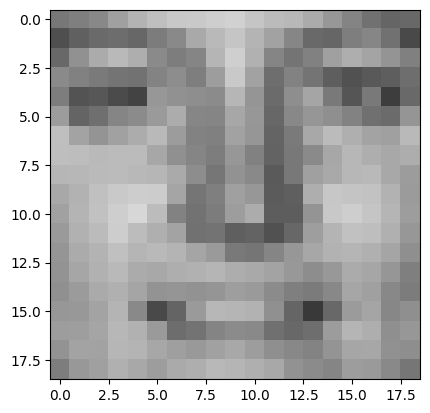

In [31]:
find_faces()